# Analyze Missclassifications

In [33]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

## Load Original Flows

In [43]:
# Configuration
dataset = "darpa2000"
scenario = "s1_inside"

In [46]:
df = pd.read_csv(
    f"../data/interim/{dataset}/{scenario}/flows_labeled/all_flows_labeled.csv"
)

df = df.sort_values("start_time").reset_index(drop=True)
df['t_rel'] = df['start_time'] - df['start_time'].min()

In [52]:
def create_phase_boundaries(df, sort_column='t_rel'):
    phase_bounds_df = (
        df.groupby('phase')
        .agg(
            first_occurrence=(sort_column, 'min'),
            last_occurrence=(sort_column, 'max')
        )
        .reset_index()
    )
    return phase_bounds_df

In [53]:
phase_bounds_time = create_phase_boundaries(df)
phase_bounds_time

,phase,first_occurrence,last_occurrence
0,0,0.000000,11649.756589
1,1,1799.665435,1824.341042
2,2,2790.877254,3333.974143
3,3,4294.134775,4402.837414
4,4,5305.272464,5357.444592
5,5,7478.960660,8383.254878


In [54]:
phase_bounds_flow_id = create_phase_boundaries(df, sort_column='flow_id')
phase_bounds_flow_id

,phase,first_occurrence,last_occurrence
0,0,f0,f9999
1,1,f21870,f21931
2,2,f24194,f26394
3,3,f29030,f29210
4,4,f31940,f33504
5,5,f100000,f99999


## Identify Misclassified Flows

### Inspect Best-Performing Model

In [47]:
results_path = f"../reports/baselines/baselines_analysis.csv"
df_results = pd.read_csv(results_path) 
df_results.head()

,experiment,accuracy,precision,recall,f1,num_errors
0,ensemble_lstm_original_class_weights_w10,0.999622,0.890752,0.979053,0.929069,19
1,ensemble_lstm_resampled_class_weights_w10,0.999523,0.859986,0.981328,0.912855,24
2,ensemble_lstm_resampled_no_class_weights_w10,0.999583,0.861520,0.981352,0.912269,21
3,multi_class_lstm_resampled_class_weights_w50,0.999563,0.940343,0.898702,0.905887,22
4,multi_class_lstm_resampled_class_weights_w100,0.999582,0.903576,0.909950,0.902462,21


In [48]:
# Hyperparameters for best-performing model
model = "ensemble_lstm"
variant = "original"
weights = "class_weights"
window_size = 10

In [49]:
processed_dir = f"../data/processed/{dataset}/{scenario}/windowed"
results_dir = f"../experiments/{dataset}/{scenario}/baselines/{model}/results"
metrics_file = f"{results_dir}/{model}_{variant}_{weights}_w{window_size}_metrics.json"

In [51]:
with open(metrics_file) as f:
    metrics = json.load(f)

misclassified_indices = metrics["misclassified_indices"]
real_flow_indices = metrics["real_flow_indices"]
mis_y_pred = metrics["y_pred"]
mis_y_true = metrics["y_true"]

mis_df = df.iloc[real_flow_indices].copy()
mis_df["y_true"] = mis_y_true
mis_df["y_pred"] = mis_y_pred


### Low Level Analysis

In [64]:
print(f"Total misclassified flows: {len(mis_df)}")
mis_df.head()

Total misclassified flows: 19


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel,y_true,y_pred
21649,f21870,9.524407e+08,9.524407e+08,0.000000,202.77.162.213,8,172.16.115.5,0,icmp,-,...,1,38,0,0,-,1,1,1799.665435,1,2
23250,f23446,9.524413e+08,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,9,342,0,0,-,1,0,2405.107653,0,2
31613,f31935,9.524441e+08,9.524441e+08,0.039273,194.27.251.21,8,172.16.112.194,0,icmp,-,...,6,228,6,228,-,1,0,5243.632337,0,2
31662,f32132,9.524442e+08,9.524442e+08,0.000000,172.16.112.194,0,197.218.177.69,8,icmp,-,...,1,38,0,0,-,1,0,5262.514702,0,1
39483,f39454,9.524464e+08,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,2,80,2,80,-,6,5,7528.056140,5,4


In [65]:
mis_only = mis_df[mis_df["y_true"] != mis_df["y_pred"]]

pd.crosstab(
    mis_only["y_true"],
    mis_only["y_pred"],
)

y_pred,0,1,2,4
y_true,,,,
0,0,2,3,0
1,0,0,1,0
5,12,0,0,1


### Phase 5 Misclassifications

In [67]:
mis_df

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel,y_true,y_pred
21649,f21870,9.524407e+08,9.524407e+08,0.000000,202.77.162.213,8,172.16.115.5,0,icmp,-,...,1,38,0,0,-,1,1,1799.665435,1,2
23250,f23446,9.524413e+08,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,9,342,0,0,-,1,0,2405.107653,0,2
31613,f31935,9.524441e+08,9.524441e+08,0.039273,194.27.251.21,8,172.16.112.194,0,icmp,-,...,6,228,6,228,-,1,0,5243.632337,0,2
31662,f32132,9.524442e+08,9.524442e+08,0.000000,172.16.112.194,0,197.218.177.69,8,icmp,-,...,1,38,0,0,-,1,0,5262.514702,0,1
39483,f39454,9.524464e+08,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,2,80,2,80,-,6,5,7528.056140,5,4
114608,f114583,9.524469e+08,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,7,581,9,6530,-,6,5,8040.431538,5,0
114612,f114585,9.524469e+08,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,9,659,12,14998,-,6,5,8040.584752,5,0
114614,f114586,9.524469e+08,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,6,542,6,5082,-,6,5,8040.665718,5,0
114616,f114587,9.524469e+08,9.524469e+08,0.053722,172.16.115.5,23083,131.84.1.31,80,tcp,http,...,7,583,9,6321,-,6,5,8040.710396,5,0
114647,f114621,9.524470e+08,9.524470e+08,0.030979,172.16.116.201,23464,131.84.1.31,80,tcp,http,...,5,394,4,2432,-,6,5,8090.326437,5,0


In [68]:
start_index = 114605
indices = range(start_index, start_index+20)
df_filtered = df.iloc[indices]
df_filtered

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel
114605,f114589,9.524469e+08,9.524469e+08,0.000779,172.16.115.5,1079,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.395936
114606,f114582,9.524469e+08,9.524469e+08,0.031471,172.16.115.5,22766,131.84.1.31,80,tcp,http,...,0,ShADdfFa,5,511,4,2432,-,6,5,8040.397506
114607,f114590,9.524469e+08,9.524469e+08,0.000779,172.16.115.5,1080,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.430035
114608,f114583,9.524469e+08,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,0,ShADadfF,7,581,9,6530,-,6,5,8040.431538
114609,f114591,9.524469e+08,9.524469e+08,0.000839,172.16.115.5,1081,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.485207
114610,f114584,9.524469e+08,9.524469e+08,0.095386,172.16.115.5,22893,131.84.1.31,80,tcp,http,...,0,ShADadfF,11,756,18,21837,-,6,5,8040.486750
114611,f114592,9.524469e+08,9.524469e+08,0.000778,172.16.115.5,1082,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.583206
114612,f114585,9.524469e+08,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,0,ShADdfFa,9,659,12,14998,-,6,5,8040.584752
114613,f114593,9.524469e+08,9.524469e+08,0.000805,172.16.115.5,1083,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.664130
114614,f114586,9.524469e+08,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,0,ShADdfFa,6,542,6,5082,-,6,5,8040.665718


In [72]:
dst_ip = "131.84.1.31"
df_filtered_dst_ip = df[df["dst_ip"] == dst_ip]

phase_counts = df_filtered_dst_ip["phase"].value_counts().sort_index()
phase_counts

phase
0        7
5    73443
Name: count, dtype: int64

## Plots

In [73]:
phase_bounds_no0 = phase_bounds_time[phase_bounds_time['phase'] != 0]
phase_bounds_no0

,phase,first_occurrence,last_occurrence
1,1,1799.665435,1824.341042
2,2,2790.877254,3333.974143
3,3,4294.134775,4402.837414
4,4,5305.272464,5357.444592
5,5,7478.960660,8383.254878


In [74]:
df.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel
0,f12289,9.524389e+08,9.524395e+08,639.014688,172.16.113.168,21582,172.16.112.50,23,tcp,-,...,0,DdAafF,652,26396,359,37644,-,6,0,0.000000
1,f2358,9.524389e+08,9.524391e+08,156.104433,172.16.113.204,22585,197.218.177.69,21,tcp,ftp,...,0,DdAFaf,41,1981,30,2173,-,6,0,2.721287
2,f0,9.524389e+08,9.524389e+08,0.101800,172.16.112.50,33354,172.16.114.50,80,tcp,http,...,0,ShADadfF,8,614,9,8261,-,6,0,5.166027
3,f1,9.524389e+08,9.524389e+08,0.001107,172.16.114.50,45135,172.16.115.20,53,udp,dns,...,0,Dd,1,72,1,159,-,17,0,5.182165
4,f23526,9.524389e+08,9.524412e+08,2245.862151,194.7.248.153,43459,172.16.115.20,23,tcp,-,...,0,DdA,199,10463,103,5600,-,6,0,11.551741


In [105]:
phase_bounds = (
    df[df['phase'] > 0]
    .groupby('phase')['t_rel']
    .agg(['min', 'max'])
)

phase_start = phase_bounds['min'].to_dict()
phase_end   = phase_bounds['max'].to_dict()

In [106]:
def is_hard_violation(row, phase_start):
    pred_phase = row['y_pred']
    t = row['t_rel']

    if pred_phase == 0:
        return False

    for prev_p in range(1, pred_phase):
        if prev_p in phase_start:
            if t < phase_start[prev_p]:
                return True

    return False

In [107]:
def is_soft_violation(row, phase_start):
    pred_phase = row['y_pred']
    t = row['t_rel']

    if pred_phase == 0:
        return False

    next_phase = pred_phase + 1

    if next_phase in phase_start:
        if t >= phase_start[next_phase]:
            return True

    return False

In [108]:
mis_df['hard_violation'] = mis_df.apply(
    is_hard_violation,
    axis=1,
    phase_start=phase_start
)

mis_df['soft_violation'] = mis_df.apply(
    is_soft_violation,
    axis=1,
    phase_start=phase_start
)

wrong = mis_df[mis_df['phase'] != mis_df['y_pred']]

hard = wrong[wrong['hard_violation']]
soft = wrong[(~wrong['hard_violation']) & (wrong['soft_violation'])]
plausible = wrong[(~wrong['hard_violation']) & (~wrong['soft_violation'])]

In [109]:
total_wrong = len(wrong)

hard_rate = len(hard) / total_wrong if total_wrong > 0 else 0
soft_rate = len(soft) / total_wrong if total_wrong > 0 else 0

print(f"Total wrong: {total_wrong}")
print(f"Hard violations: {len(hard)} ({hard_rate:.2%})")
print(f"Soft violations: {len(soft)} ({soft_rate:.2%})")

Total wrong: 19
Hard violations: 0 (0.00%)
Soft violations: 5 (26.32%)


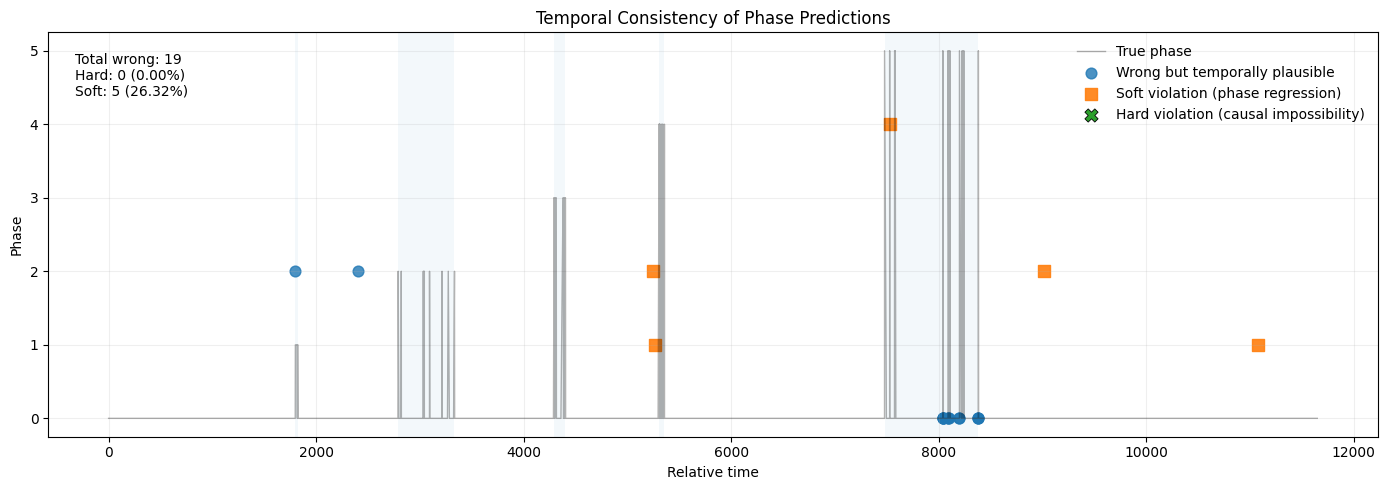

In [111]:
plt.figure(figsize=(14, 5))

# --- True phase over time ---
plt.plot(
    df['t_rel'],
    df['phase'],
    color='black',
    linewidth=1,
    alpha=0.3,
    label="True phase"
)

# --- Shaded phase intervals ---
for phase, bounds in phase_bounds.iterrows():
    plt.axvspan(
        bounds['min'],
        bounds['max'],
        alpha=0.05
    )

# --- Plausible errors ---
plt.scatter(
    plausible['t_rel'],
    plausible['y_pred'],
    s=60,
    alpha=0.8,
    label='Wrong but temporally plausible'
)

# --- Soft violations ---
plt.scatter(
    soft['t_rel'],
    soft['y_pred'],
    s=70,
    marker='s',
    alpha=0.9,
    label='Soft violation (phase regression)'
)

# --- Hard violations ---
plt.scatter(
    hard['t_rel'],
    hard['y_pred'],
    s=90,
    marker='X',
    edgecolor='black',
    linewidth=0.6,
    zorder=3,
    label='Hard violation (causal impossibility)'
)

# --- Cosmetics ---
plt.xlabel("Relative time")
plt.ylabel("Phase")
plt.title("Temporal Consistency of Phase Predictions")

plt.yticks(sorted(df['phase'].unique()))
plt.grid(alpha=0.2)

plt.text(
    0.02,
    0.95,
    f"Total wrong: {total_wrong}\n"
    f"Hard: {len(hard)} ({hard_rate:.2%})\n"
    f"Soft: {len(soft)} ({soft_rate:.2%})",
    transform=plt.gca().transAxes,
    verticalalignment='top'
)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()